# Constructing 1D case

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

class Chain_1D():
    def __init__(self, N:int, r:float, kappa:float):
        self.N = N
        self.r = r
        self.kappa = kappa
        self.theta = np.array([np.pi*2*random.random() for i in range(N)])
        J_tilde_R = np.array(np.random.choice([-1.0, 1.0], size=(N), p=(0.5, 0.5)))
        J_tilde_L = np.array([np.random.choice([J_tilde_R[i], -J_tilde_R[i]], p=(0.5+r/2, 0.5-r/2)) for i in range(N)])
        
        self.J_R = np.add(kappa*np.copy(J_tilde_R), (1-kappa)*np.ones((N)))
        self.J_L = np.add(kappa*np.copy(J_tilde_L), (1-kappa)**np.ones((N)))  

    def evolve_and_record(self, t:float, dt:float, randomize_start=False):
        N=self.N
        n_T = int(t//dt)
        theta_history =[]
        if randomize_start:
            self.__init__(N, self.r, self.kappa)
        for timestep in range(n_T):
            if timestep%int(1/dt) == 0:
                theta_history.append(self.theta%(np.pi))
            theta_dot = np.array([self.J_R[0]*np.sin(self.theta[1] - self.theta[0])]+
                                 [(self.J_R[i]*np.sin(self.theta[(i+1)%N] - self.theta[i]) + self.J_L[(i-1)%N]*np.sin(self.theta[(i-1)%N] - self.theta[i])) for i in range(1, N-1)]
                                 +[self.J_L[N-1]*np.sin(self.theta[N-2] - self.theta[N-1])])
            self.theta = np.add(self.theta, dt*theta_dot)
        return np.array(theta_history)

In [4]:
def viz(history, r=None, k=None):
    fix, ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xlabel('Spin site $i$')
    ax.set_ylabel('Normalized Time $\sigma_J t$')
    ax.set_title(f'Angles over Time mod($\pi$) \n r={r}, $\kappa$={k}')
    col = ax.pcolor(history, cmap='twilight')#, vmin=0, vmax=np.pi)
    plt.colorbar(mappable=col)
    plt.show()

In [5]:
def corr_x(slice: list, x: int):
    C_x = 1/len(slice) * np.abs(np.sum(np.exp([2*1.0j*(slice[i] - slice[(i+x)%len(slice)]) for i in range(len(slice))]))) 
    return C_x

# Spatial Kuramoto OP

In [6]:
import scipy

In [357]:
def power_law(x, n):
    return x**n

In [358]:
def calc_kuramoto(ls:list, windowsize:int):
    Ms =[]
    for i in range(len(ls)):
        M = np.abs(np.sum(np.array([np.exp(2*1.0j*ls[(i+j-int(windowsize/2))%len(ls)]) for j in range(windowsize)])))
        Ms.append(M)
    return np.mean(np.array(Ms))

In [365]:
def eval_phase_kuramoto(r, kappa, T=1000, N=100):
    dt=0.05
    chain = Chain_1D(N, r=r, kappa=kappa)
    history_ordered = chain.evolve_and_record(T, dt)
    #viz(history_ordered)
    ydata = [calc_kuramoto(history_ordered[-1], i) for i in range(20)]
    xdata = range(20)
    try:
        popt, pcov = scipy.optimize.curve_fit(power_law, xdata, ydata)
        #print(rf'r={r}, $\alpha$={alpha}, gives n={round(popt[0], 3)}')
        return popt[0]
    except:
        return 5

In [370]:
rs = []
kappas = []
phases=[]
phase = []
r_pix = 31
kappa_pix= 41
for r in np.linspace(-1.0, 1.0, r_pix):
    p=[]
    for kappa in np.linspace(0.0, 1.0, kappa_pix):
        n = np.mean([eval_phase_kuramoto(r=r, kappa=kappa, N=100, T=500) for count in range(5)])
        phases.append(n)
        p.append(n)
        rs.append(r)
        kappas.append(kappa)
    print(f'searched r={round(r,2)}')
    phase.append(p)


searched r=-1.0
searched r=-0.93
searched r=-0.87
searched r=-0.8
searched r=-0.73
searched r=-0.67
searched r=-0.6
searched r=-0.53
searched r=-0.47
searched r=-0.4
searched r=-0.33
searched r=-0.27
searched r=-0.2
searched r=-0.13
searched r=-0.07
searched r=0.0
searched r=0.07
searched r=0.13
searched r=0.2
searched r=0.27
searched r=0.33
searched r=0.4
searched r=0.47
searched r=0.53
searched r=0.6
searched r=0.67
searched r=0.73
searched r=0.8
searched r=0.87
searched r=0.93
searched r=1.0


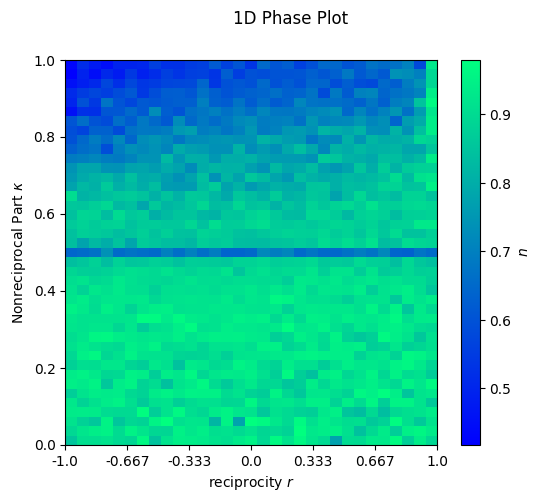

In [371]:
plt.figure(figsize=(6,5))
plt.imshow(np.flip(np.transpose(phase), 0), cmap='winter', interpolation='none', aspect='auto')
plt.xticks(np.linspace(-0.5, -0.5+r_pix, int(r_pix/4)), labels=np.round(np.linspace(-1.0, 1.0, int(r_pix/4)), 3))
plt.yticks(np.linspace(-0.5, -0.5+kappa_pix, int(kappa_pix/6)), labels=np.round(np.linspace(1.0, 0.0, int(kappa_pix/6)), 3))
plt.xlabel('reciprocity $r$')
plt.ylabel(r'Nonreciprocal Part $\kappa$')
plt.suptitle('1D Phase Plot')
plt.colorbar(label=r'$n$')

# Temporal Correlations

In [61]:
def wiener_entropy(history):
    flatness=[]
    for i in range(len(history[-1])):
        power_spectrum = np.square(np.absolute(np.fft.rfft(history[:, i])))
        gmean = scipy.stats.mstats.gmean(power_spectrum)
        mean = np.mean(power_spectrum)
        spectral_flatness = gmean/mean
        flatness.append(spectral_flatness)
    return np.mean(flatness)


In [84]:
def eval_phase_wiener(r, kappa, T=2000, N=200):
    dt=0.05
    chain = Chain_1D(N, r=r, kappa=kappa)
    history_ordered = chain.evolve_and_record(T, dt)
    return 1-wiener_entropy(history_ordered) #-np.log(wiener_entropy(history_ordered))

In [401]:
def wiener_entropy(history):
    flatness=[]
    for i in range(len(history[-1])):
        #power_spectrum = np.square(np.absolute(np.fft.rfft(np.subtract(history[:,i], np.pi/2))))
        power_spectrum = np.square(np.absolute(np.fft.fft(np.exp(2*1j*history[:,i]))))
        gmean = scipy.stats.mstats.gmean(power_spectrum)
        mean = np.mean(power_spectrum)
        spectral_flatness = (gmean/mean)
        flatness.append(spectral_flatness)
    return np.mean(flatness)

In [406]:
rs = []
kappas = []
phases=[]
phase = []
r_pix = 21
kappa_pix= 41
for r in np.linspace(-1.0, 1.0, r_pix):
    p=[]
    for kappa in np.linspace(0.0, 1.0, kappa_pix):
        n = np.mean([eval_phase_wiener(r=r, kappa=kappa, N=100, T=1000) for count in range(3)])
        phases.append(n)
        p.append(n)
        rs.append(r)
        kappas.append(kappa)
    print(f'searched r={round(r,2)}')
    phase.append(p)


searched r=-1.0
searched r=-0.9
searched r=-0.8
searched r=-0.7
searched r=-0.6
searched r=-0.5
searched r=-0.4
searched r=-0.3
searched r=-0.2
searched r=-0.1
searched r=0.0
searched r=0.1
searched r=0.2
searched r=0.3
searched r=0.4
searched r=0.5
searched r=0.6
searched r=0.7
searched r=0.8
searched r=0.9
searched r=1.0


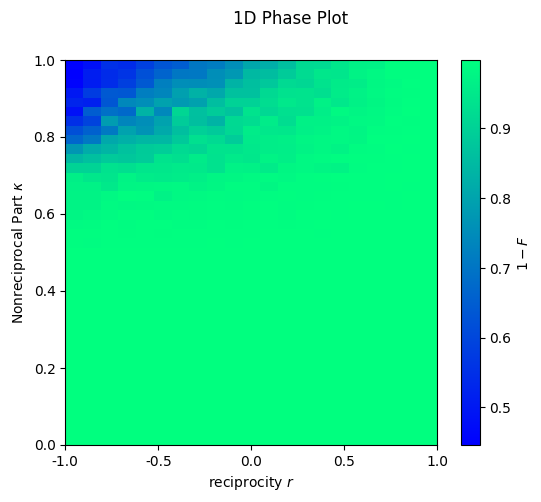

In [407]:
plt.figure(figsize=(6,5))
plt.imshow(np.flip(np.transpose(phase), 0), cmap='winter', interpolation='none', aspect='auto')
plt.xticks(np.linspace(-0.5, -0.5+r_pix, int(r_pix/4)), labels=np.round(np.linspace(-1.0, 1.0, int(r_pix/4)), 3))
plt.yticks(np.linspace(-0.5, -0.5+kappa_pix, int(kappa_pix/6)), labels=np.round(np.linspace(1.0, 0.0, int(kappa_pix/6)), 3))
plt.xlabel('reciprocity $r$')
plt.ylabel(r'Nonreciprocal Part $\kappa$')
plt.suptitle('1D Phase Plot')
plt.colorbar(label=r'$1-F$')

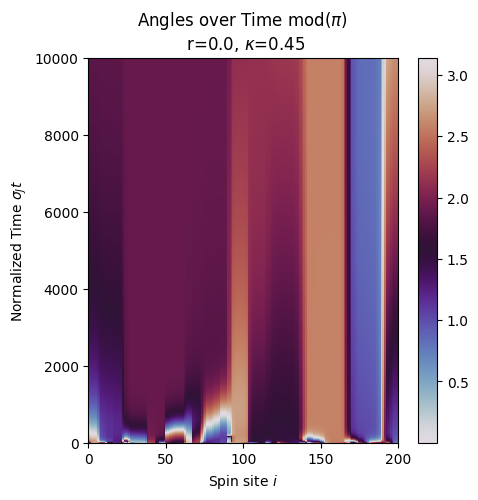

In [400]:
chain = Chain_1D(N=200, r=0.0, kappa=0.45)
history_frozen = chain.evolve_and_record(t=10000, dt=0.05)
viz(history_frozen, r=0.0, k=0.45)


# Constructing Histories

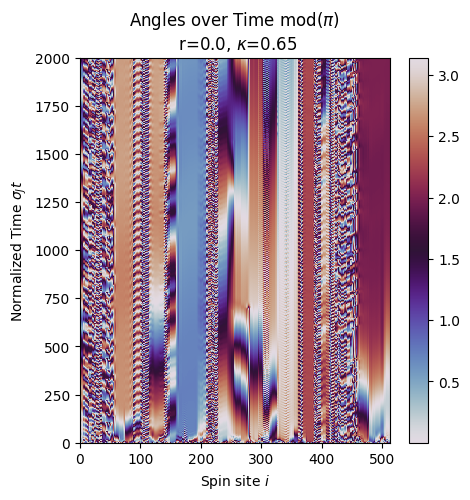

In [10]:
chain = Chain_1D(N=512, r=0.0, kappa=0.65)
his = chain.evolve_and_record(t=2000, dt=0.05)
viz(his, r=0.0, k=0.65)

In [11]:
def C_t(history, t_W, t):
    spin_t_W = history[t_W, :]
    spin_t_W_plus_t = history[t_W+t, :]
    #C_t = np.abs(np.mean(np.exp(2*1j*np.subtract(spin_t_W_plus_t,spin_t_W))))
    #C_t = np.abs(np.mean(np.exp(2*1j*np.subtract(spin_t_W_plus_t,spin_t_W)))) - np.abs(np.mean(np.exp(2*1j*spin_t_W_plus_t))*np.mean(np.exp(-2*1j*spin_t_W)))
    C_t = np.mean(np.exp(2*1j*np.subtract(spin_t_W_plus_t,spin_t_W))) - np.mean(np.exp(2*1j*spin_t_W_plus_t))*np.mean(np.exp(-2*1j*spin_t_W))
    return C_t

In [12]:
def mean_C_t(runs, runtime, T, t_W, N=1024, r=0.0, kappa=0.65):
    C_ts = []
    for j in range(runs):
        chain = Chain_1D(N=N, r=r, kappa=kappa)
        his = chain.evolve_and_record(t=runtime, dt=0.05)
        C_ts.append([C_t(his, int(t_W), i) for i in range(T)])
    return np.mean(np.array(C_ts), axis=0)

In [13]:
chain = Chain_1D(N=100, r=0.0, kappa=0.65)
histories = [chain.evolve_and_record(t=10000, dt=0.1, randomize_start=True) for i in range(1000)]

In [42]:
histories_1D = np.array(histories)[:, ::10, :]
np.save('histories_1D', histories_1D)

In [38]:
histories_1D = np.load('histories_1D.npy')

In [43]:
histories_1D.shape

(1000, 1000, 100)

# Temporal Correlations

In [15]:
def calc_C_t_W(t_w, histories):
    return np.array([np.abs(np.mean([C_t(history, t_w, t) for history in histories])) for t in range(len(histories[0]) - t_w)])

In [16]:
t_ws = [32, 64, 128, 256, 512, 1024, 2056, 4112]
a=[]
b=[]
for t_w in t_ws:
    a.append(np.arange(len(histories[0]) - t_w))
    b.append(calc_C_t_W(int(t_w), histories)) 

Text(0.5, 1.0, 'Temporal Correlations')

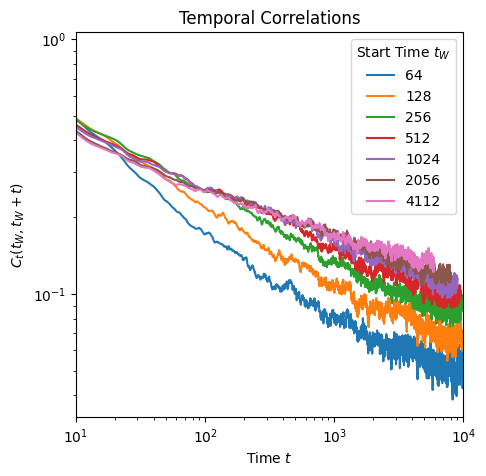

In [33]:
t_ws = [32, 64, 128, 256, 512, 1024, 2056, 4112]
plt.figure(figsize=(5,5))
for i in range(1, len(t_ws)):
    plt.plot(a[i], b[i], label=str(t_ws[i]))
#plt.ylim(bottom=0.003)
plt.xlim(left=10, right=10000)
plt.yscale('log')
plt.xscale('log')
plt.legend(title='Start Time $t_W$')
plt.xlabel('Time $t$')
plt.ylabel('$C_t(t_W, t_W+t)$')
plt.title('Temporal Correlations')

# Spatial Correlations

In [50]:
def C_x(slice, x):
    N = len(slice)
    return np.mean([np.exp(2*1j*np.subtract(slice[i],slice[(i+x)%N])) for i in range(N)])

In [107]:
def average_Cx(histories, x, t):
    slices = histories[:, t, :]
    return np.abs(np.mean([C_x(histories[i, t, :], x) for i in range(1000)]))

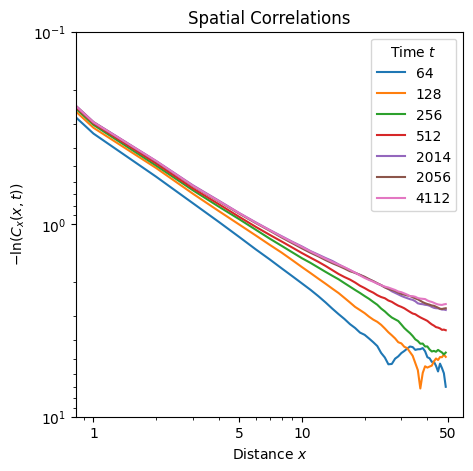

In [109]:
import matplotlib
plt.figure(figsize=(5,5))
plt.yscale('log')
plt.xscale('log')
ts=[6.4, 12.8, 25.6, 51.2, 201.4, 205.6, 411.2]
for t in ts:    
    plt.plot([-np.log(average_Cx(histories_1D, x, int(t))) for x in range(50)], label=str(int(t*10)))
plt.xlabel('Distance $x$')
plt.legend(title = 'Time $t$')
plt.ylabel('$-\ln(C_x(x, t))$')
plt.title('Spatial Correlations')
plt.xticks([1, 5, 10, 50])
plt.ylim(bottom=0.1, top=10)
ax1 = plt.gca()
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.gca().invert_yaxis()

In [104]:
chain = Chain_1D(N=2000, r=0.0, kappa=0.65)
histories_large = [chain.evolve_and_record(t=10000, dt=0.1, randomize_start=True) for i in range(1)]

In [100]:
def average_Cx(histories, x, t):
    return np.abs(np.mean([C_x(np.array(histories)[0, t, :], x) for i in [0]]))

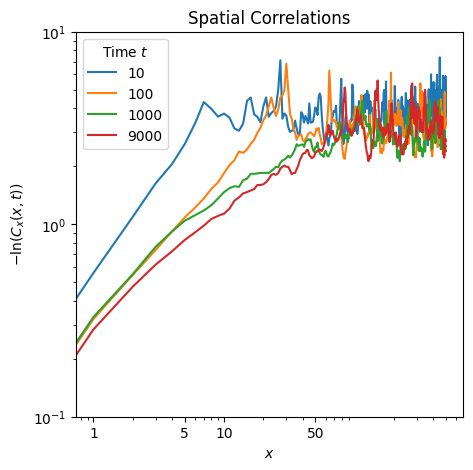

In [105]:
plt.figure(figsize=(5,5))
plt.yscale('log')
plt.xscale('log')
ts=[10, 100, 1000, 9000]
for t in ts:    
    plt.plot([-np.log(average_Cx(histories_large, x, int(t))) for x in range(500)], label=str(int(t)))
plt.xlabel('$x$')
plt.legend(title = 'Time $t$')
plt.ylabel('$-\ln(C_x(x, t))$')
plt.title('Spatial Correlations')
plt.xticks([1, 5, 10, 50])
plt.ylim(bottom=0.1, top=10)
ax1 = plt.gca()
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())